In [50]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
mnist

{'data':        pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
 0           0       0       0       0       0       0       0       0       0   
 1           0       0       0       0       0       0       0       0       0   
 2           0       0       0       0       0       0       0       0       0   
 3           0       0       0       0       0       0       0       0       0   
 4           0       0       0       0       0       0       0       0       0   
 ...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
 69995       0       0       0       0       0       0       0       0       0   
 69996       0       0       0       0       0       0       0       0       0   
 69997       0       0       0       0       0       0       0       0       0   
 69998       0       0       0       0       0       0       0       0       0   
 69999       0       0       0       0       0       0       0       0       0   
 
      

In [51]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape
print(type(X), type(y) )


<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


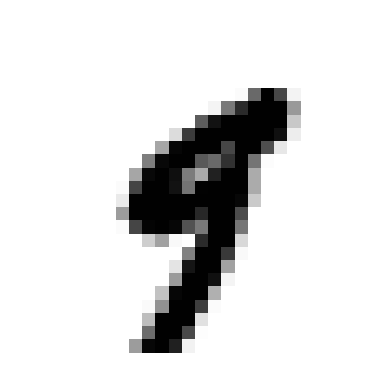

In [77]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X.iloc[11].values
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()


In [53]:
y[11]

'9'

In [54]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:],y[:60000], y[60000:]

In [55]:
print(X_train.shape[0])

60000


In [59]:
import numpy as np
shuffle_index = np.random.permutation(X_train.shape[0])
X_train, y_train = X_train.to_numpy(), y_train.to_numpy()
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [64]:
y_train = y_train.astype(int)
y_train_5 = (y_train == 9)
y_test_5 = (y_test == 9)
print(np.unique(y_train_5))  # Should print something like [0 1]
print(y_train_5.shape)
print(X_train.shape)
print(np.unique(y_train))  # Should include both 5 and other digits

[False  True]
(60000,)
(60000, 784)
[0 1 2 3 4 5 6 7 8 9]


In [65]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [91]:
sgd_clf.predict([X.iloc[11].values])



array([ True])

In [98]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=None)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    X_test_folds = X_train[test_index]
    y_train_folds = y_train_5[train_index]
    y_test_folds = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum (y_pred == y_test_folds)
    print(n_correct / len(y_pred))
    


0.9541
0.9517
0.95865


In [99]:
# The cross validation score does not work for classifier because since we are taking a value and binary checking it against a dataset,
# which have to give [0 or 1] each time, meaning in this example it will give 90+% times that this is not 5 (binary 0), which becomes its prediction score
# Below code is just for practice
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9541 , 0.9517 , 0.95865])

In [105]:
# Better way of measuring score for classifier is with confusion matrix (using precision and recall --> F1 score)
from sklearn.model_selection import cross_val_predict 
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [106]:
# below is the code for confusion matrix 
# e.g array([[53094,  1485], [ 1226,  4195]]) ---> array([[True Neg,  False Pos], [ False Neg,  True Positive]])
# prefict model will have 0 as value on False Pos and False Neg
from sklearn.metrics import confusion_matrix, precision_score, recall_score
confusion_matrix(y_train_5, y_train_pred)

#below is precision and recall score ---> improving one, decrease other (inversely proportional, Tradeoff)
precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
print(f"Precision measures the accuracy of against the predicted result, i.e --> {precision}")
print(f"Recall measures the completeness of against the number of its instances in dataset, i.e --> {recall}")

Precision measures the accuracy of against the predicted result, i.e --> 0.738556338028169
Recall measures the completeness of against the number of its instances in dataset, i.e --> 0.7738424644899465


In [116]:
# Experimenting with threshold lets us balance between precision and recall tradeoff, here is e.g
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores) # y_score was 8214
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(f"When threshold is 0: {y_some_digit_pred}")
threshold = -8215 
y_some_digit_pred = (y_scores > threshold)
print(f"When threshold is -8215: {y_some_digit_pred}")
# lowering threshold, increases the precision

[-8214.64488974]
When threshold is 0: [False]
When threshold is -8215: [ True]


In [119]:
# How can we decide to us what threshold
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method= "decision_function")
y_scores

array([-21287.76208025,  -9363.96272734,  -5844.86312167, ...,
          219.05803802, -29833.35319802, -29249.01906338])

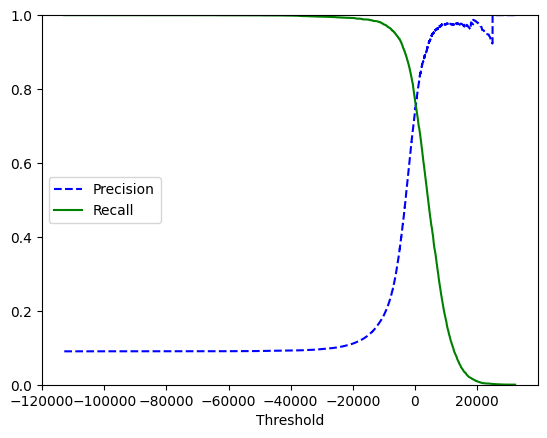

In [124]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
def plot_precision_recall_vs_threshold(precision, recall, thresholds):
    plt.plot(thresholds, precision[:-1], "b--", label="Precision")
    plt.plot(thresholds, recall[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc = "center left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [146]:
y_train_pred_90 = (y_scores > 5000)
print(precision_score(y_train_5, y_train_pred_90),",  ",
recall_score(y_train_5, y_train_pred_90))

0.9348659003831418 ,   0.4501014572957019


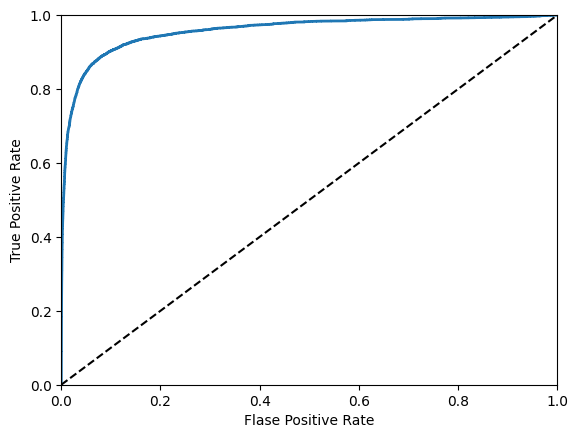

AUC: 0.9578730463658535


In [151]:
from sklearn.metrics import roc_curve
#ROC is Receiver Operating Characteritics 
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0, 1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_train_5, y_scores)
print("AUC:", auc)


In [152]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method= "predict_proba")
y_probas_forest

array([[1.  , 0.  ],
       [0.96, 0.04],
       [1.  , 0.  ],
       ...,
       [0.28, 0.72],
       [1.  , 0.  ],
       [0.98, 0.02]])

In [153]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

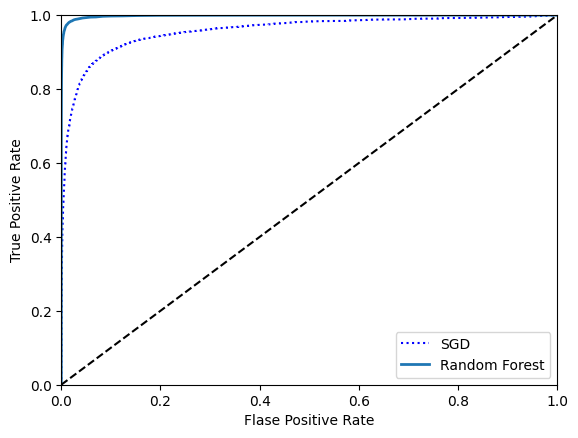

In [155]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.show()

In [157]:
forest_auc= roc_auc_score(y_train_5, y_scores_forest)
print(forest_auc)

0.9983841449222435


In [160]:
y_forest_train_pred = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print(precision_score(y_train_5, y_forest_train_pred), ",  ", recall_score(y_train_5, y_forest_train_pred))

0.9892902141957161 ,   0.8690278546393654


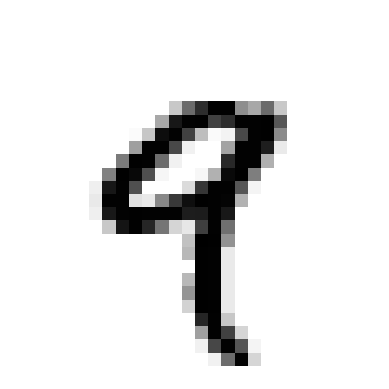

'9'

In [248]:

indices = np.where(y == '9')[0]
some_digit = X.iloc[indices[0]].values
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
y[indices[0]]

In [227]:
# multiclass classifier
y_train = y_train.astype(int)
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])


array([5])

In [243]:
some_digit_scores = forest_clf.predict_proba([some_digit])
print(some_digit_scores)
predict_digit = np.argmax(some_digit_scores).item()


[[0.01 0.   0.   0.96 0.   0.   0.   0.   0.02 0.01]]


In [244]:
forest_clf.classes_
forest_clf.classes_[predict_digit].item()


3

In [251]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(random_state=42))

In [252]:
pred_ovo = ovo_clf.predict([some_digit])
print(pred_ovo)
len(ovo_clf.estimators_)

[9]


45

In [253]:
print(cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy"))
print(cross_val_score(ovo_clf, X_train, y_train, cv=3, scoring="accuracy"))


[0.82365 0.87165 0.89185]
[0.9183 0.918  0.9132]


In [255]:
print(cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy"))

[0.96705 0.96745 0.9643 ]


In [256]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
print(cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy"))


/Users/admin/Desktop/ml/housing/myapp/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[0.9077  0.89905 0.89525]


In [257]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/Users/admin/Desktop/ml/housing/myapp/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([[5594,    0,   15,    8,    8,   40,   33,    4,  220,    1],
       [   0, 6428,   42,   23,    3,   41,    5,    7,  179,   14],
       [  23,   30, 5241,   96,   73,   19,   68,   36,  365,    7],
       [  26,   23,  113, 5253,    2,  199,   25,   42,  383,   65],
       [  10,   16,   47,   13, 5224,   10,   33,   19,  301,  169],
       [  22,   17,   30,  156,   54, 4483,   77,   18,  497,   67],
       [  29,   22,   49,    2,   45,   93, 5538,    2,  138,    0],
       [  19,   12,   50,   25,   53,   12,    4, 5688,  182,  220],
       [  16,   69,   38,   90,    2,  127,   29,    7, 5435,   38],
       [  25,   21,   28,   60,  124,   37,    1,  166,  331, 5156]])

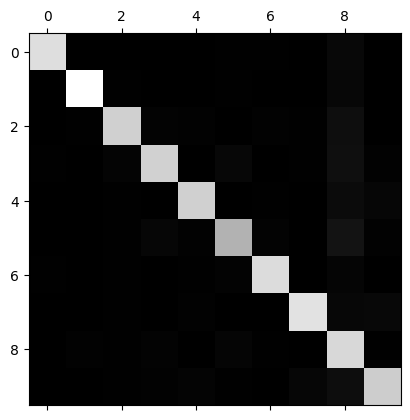

In [258]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

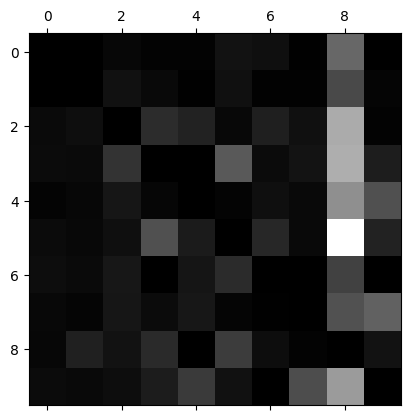

In [259]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [260]:
#Multilabel Classification
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >=7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [262]:
indices = np.where(y == '5')[0]
some_digit = X.iloc[indices[0]].values
knn_clf.predict([some_digit])

array([[False,  True]])

In [264]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)


In [267]:
from sklearn.metrics import f1_score 
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778812465222976

In [268]:
# Multioutput Classification
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise 
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise 
y_train_mod = X_train
y_test_mod = X_test

In [275]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

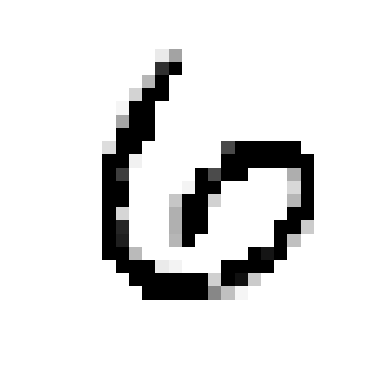

In [278]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[11]])
plot_digits(clean_digit)